<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/gradient_boosting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price Prediction

## Project Overview

**Project Description**

The used car sales service `Rusty but Trusty` (Russian: "Не бит, не крашен") is developing an app to attract new customers. The app will allow users to quickly find out the market value of their cars. You have access to historical data: technical specifications, trim levels, and prices. Your goal is to build a model to determine the car's value.

**The client values**:
- Prediction quality (RMSE);
- Prediction speed;
- Training time.

**Project Goal**

Develop a machine learning model to predict the market value of cars based on their characteristics. The model must meet the quality requirement (`RMSE < 2500`) while balancing training and prediction speed.

**Project Workflow**

- [Data Loading](#Loading) – Open and explore the datasets.
- [Data Preprocessing](#Preprocessing) – Handle missing values, anomalies, and drop non-informative features.
- [Data Preparation](#Preparation) – Split the dataset into training, validation, and test sets.
- [Model Training](#Training) – Test various algorithms, including LightGBM, RandomForestRegressor, and a non-boosting baseline LinearRegression.
- [Model Analysis](#Analysis) – Evaluate RMSE, training time, and prediction time to select the best model based on the client's criteria.
- [Final Test Set Validation](#Test) - Perform the final prediction on the test set using the best model.
- [Feature Importance](#Importance) - Analyzing which features contribute most to the model's decisions.
- [General Conclusion](#Conclusion)

## Data Description

- `DateCrawled`	Date the profile was downloaded from the database
- `VehicleType`	Body type
- `RegistrationYear`	Year of car registration
- `Gearbox`	Transmission type
- `Power`	Horsepower (hp)
- `Model`	Car model
- `Kilometer`	Mileage (km)
- `RegistrationMonth`	Month of car registration
- `FuelType`	Fuel type
- `Brand`	Car brand
- `Repaired`	Whether the car has been repaired (damaged) before or not
- `DateCreated`	Date the listing was created
- `NumberOfPictures`	Number of car photos
- `PostalCode`	Postal code of the user
- `LastSeen`	Date of the last user activity

**Target Variable**
- `Price` — Price (Euro)

## <a name='Loading'></a> Data Loading

### Libraries and module import

In [3]:
!pip install lightgbm -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [38]:
import time
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Reading

In [5]:
# Data reading
df = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/autos.csv')

# Checking first raws
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# Checking basic and statistical information
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- **Missing Values**: Features such as `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Repaired` contain missing values. These fields might have been optional for users to fill.
- **Outliers*: * In the `Power` feature, the maximum value is 13 times larger than the third quartile ($Q3$).In the `Price` feature, the maximum value is 3 times larger than $Q3$.The `RegistrationYea`r shows a minimum of 1000 and a maximum of 9999, which clearly indicates anomalies.
- **Irrelevant Features**: Features that do not influence the target variable (`price`) should be removed: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, and `LastSeen`.

## <a name='Preprocessing'></a> Data Preprocessing

In [7]:
# First, let's examine the data extraction dates by converting them to datetime format
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
print(df['DateCrawled'].min(), df['DateCrawled'].max())

2016-03-05 14:06:22 2016-04-07 14:36:58


In [8]:
# Check for duplicates
df.duplicated().sum()

np.int64(4)

In [9]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# ReCheck
df.duplicated().sum()

np.int64(0)

In [10]:
# Check the percentage of missing values
df.isna().mean() * 100

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.579487
RegistrationYear,0.000000
Gearbox,5.596772
Power,0.000000
Model,5.560651
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.282802


In [11]:
# Explore unique values for 'VehicleType'
df['VehicleType'].value_counts()

,count
VehicleType,
sedan,91457
small,79830
wagon,65165
bus,28775
convertible,20203
coupe,16161
suv,11996
other,3288


In [14]:
# Replace missing values in 'VehicleType' with 'other'
df['VehicleType'] = df['VehicleType'].fillna('other')

In [13]:
# Explore unique values for 'Gearbox'
df['Gearbox'].value_counts()

,count
Gearbox,
manual,268249
auto,66283


In [15]:
# Replace missing values in 'Gearbox' with 'unknown'
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [16]:
# Explore unique values for 'Model'
df['Model'].value_counts()

,count
Model,
golf,29232
other,24420
3er,19761
polo,13066
corsa,12570
...,...
i3,8
serie_3,4
rangerover,4


In [17]:
# Replace missing values in 'Model' with 'other'
df['Model'] = df['Model'].fillna('other')

In [18]:
# Explore unique values for 'FuelType'
df['FuelType'].value_counts()

,count
FuelType,
petrol,216349
gasoline,98719
lpg,5310
cng,565
hybrid,233
other,204
electric,90


In [19]:
# Rename 'gasoline' to 'petrol' as both refer to the same fuel type in this context
df['FuelType'] = df['FuelType'].replace(['gasoline'], 'petrol')

# Fill missing values in 'FuelType' with 'other'
df['FuelType'] = df['FuelType'].fillna('other')

In [20]:
# Fill missing values in 'Repaired' with 'other'
df['Repaired'] = df['Repaired'].fillna('other')

In [21]:
# Re-check for missing values
df.isna().sum()

,0
DateCrawled,0
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0


In [22]:
# Explore unique values for 'RegistrationYear'
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [23]:
# Filter data: keep years between 1900 and 2016
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1900)]

# Verify unique values for 'RegistrationYear' again
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960,
       1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962,
       1929, 1957, 1940, 1949, 1937, 1951, 1953, 1933, 1950, 1948, 1952,
       1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1919, 1931, 1915, 1920, 1947, 1927, 1946])

### Feature Engineering: Car Age

We have cars of various ages. It is hypothesized that pricing models differ significantly based on the car's age. We will calculate the car's age and categorize it to improve model performance.

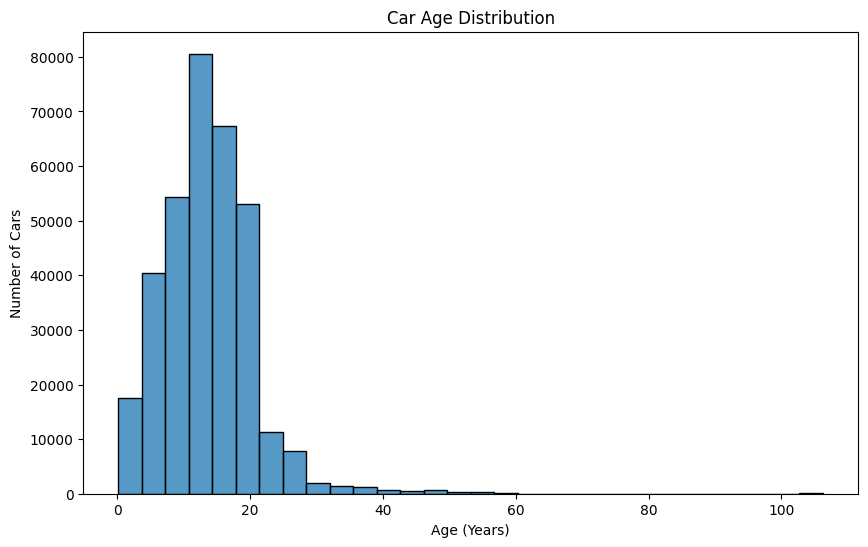

In [24]:
# Convert 'RegistrationYear' to datetime
df['RegistrationYear'] = pd.to_datetime(df['RegistrationYear'], format='%Y')

# Create a new feature 'Age' (calculated in years at the time of data crawling)
df['Age'] = (df['DateCrawled'] - df['RegistrationYear']).dt.days / 365.25

# Visualize the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30)
plt.title('Car Age Distribution')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Cars')
plt.show()

- There is a prominent peak in the 0–20 years range, indicating that most cars in the dataset are relatively "young".
- Less pronounced peaks appear around 20–40 years.
- The distribution has a long right tail, representing a small number of vintage or very old cars.

In [25]:
# Define age categories
bins = [0, 4, 8, 12, 21, 31, df['Age'].max()]
labels = ['new', 'fresh', 'used', 'used +', 'old', 'retro']
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Drop 'RegistrationYear' to avoid multicollinearity
df = df.drop('RegistrationYear', axis=1)

# Remove rows where 'Age' could not be calculated (NaN)
df.dropna(subset=['Age'], inplace=True)

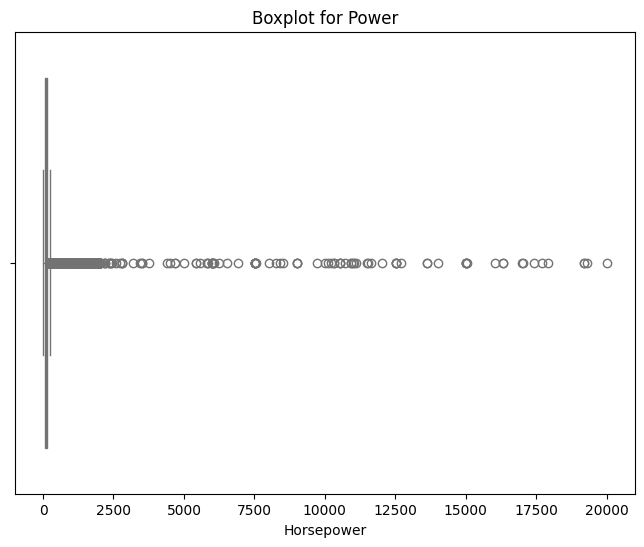

In [26]:
# Check for outliers in 'Power' using a Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Power'], color='lightgreen')
plt.title('Boxplot for Power')
plt.xlabel('Horsepower')
plt.show()

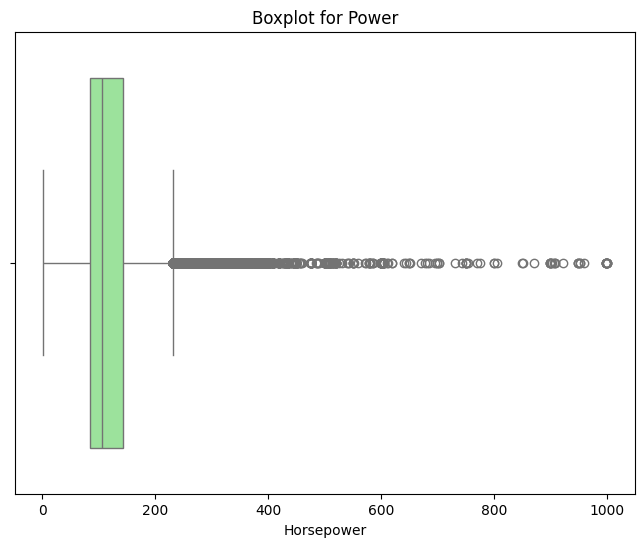

In [27]:
# Replace 0 values in 'Power' with the median
df['Power'] = df['Power'].mask(df['Power'] == 0, df['Power'].median())

# Limit Power to 1000 hp (values above are likely anomalies or extreme supercars)
df = df.query('Power <= 1000')

# Check for outliers in 'Power' using a Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Power'], color='lightgreen')
plt.title('Boxplot for Power')
plt.xlabel('Horsepower')
plt.show()

<Axes: >

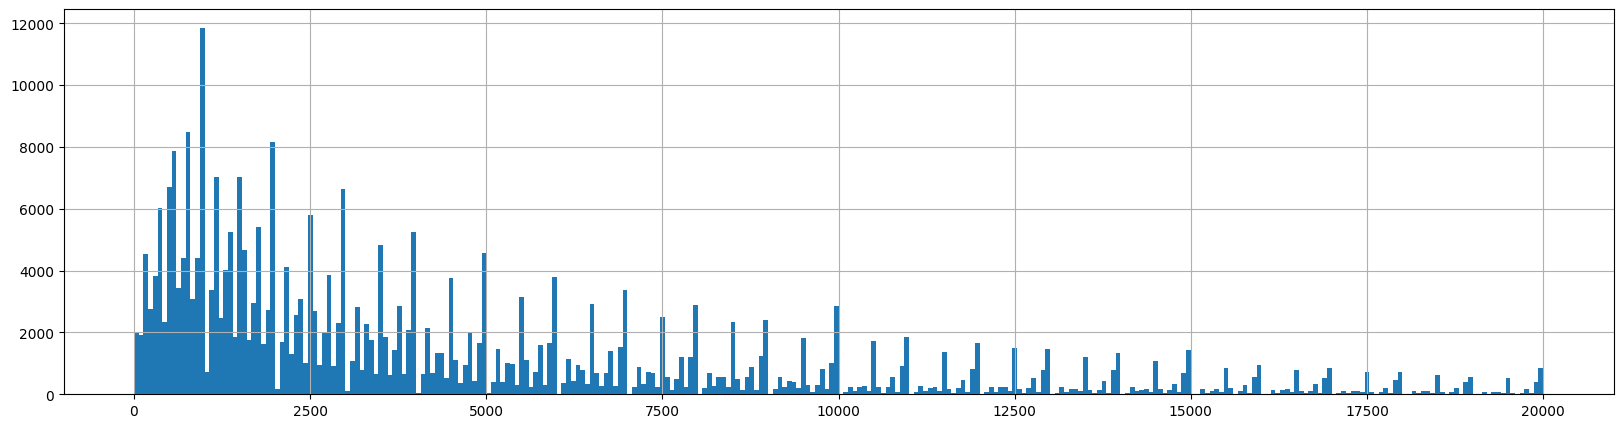

In [28]:
# Remove entries with 0 price from the target variable
df = df.query('Price > 0')

# Visualize the target variable distribution
df['Price'].hist(bins=300, figsize=(20,5))

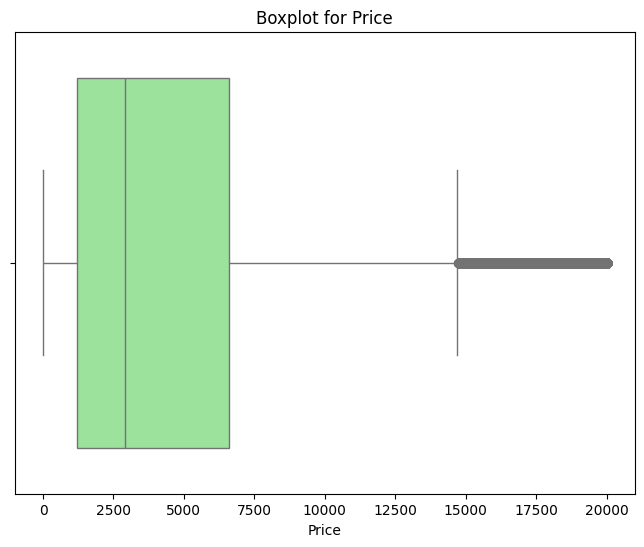

In [29]:
# Boxplot for Price
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Price'], color='lightgreen')
plt.title('Boxplot for Price')
plt.xlabel('Price')
plt.show()

There are some emissions after 1500, but we'll leave them.

In [30]:
# Drop non-informative features
df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
        axis=1, inplace=True)

# Re-check for duplicates after dropping columns
df.duplicated().sum()

np.int64(65342)

In [31]:
# Remove remaining duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Re-check
df.duplicated().sum()

np.int64(0)

- **Duplicates**: Identified and removed.
- **Missing Values**: Handled in `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Repaired` by filling with `other` or `unknown`.
- **ower Feature**: Anomalies were filtered; values are now capped at 1,000 hp, and zero values were replaced with the median.
- **Registration Year & Age**: Data was filtered between 1900 and 2016. A new categorical feature `Age` (new, fresh, used, used +, old, retro) was created based on the difference between the crawl date and registration.
- **Target Variable**: Records with zero price were removed to ensure model quality.
- **Feature Selection**: Irrelevant technical columns (e.g., `PostalCode`, `DateCrawled`) were dropped.

## <a name='Preparation'></a> Data Preparation

The `LinearRegression` model requires categorical data to be encoded using `One-Hot Encoding` (OHE) and numerical data to be scaled using `StandardScaler`. This is because linear models are sensitive to the scale of features and cannot process categorical variables in text format directly.

In [33]:
# Separate features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

# Define lists for feature types
categorical_features = ['VehicleType', 'Age', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numerical_features = ['Power', 'Kilometer']

# Split the data into training and test sets (75/25 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

For the linear model, we use OneHotEncoder to create dummy variables and StandardScaler to bring numerical features to a common scale.

In [35]:
# Initialize OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data and transform both sets to prevent data leakage
X_train_ohe = ohe_encoder.fit_transform(X_train[categorical_features])
X_test_ohe = ohe_encoder.transform(X_test[categorical_features])

# Convert the encoded arrays back to DataFrames
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder.get_feature_names_out(), index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder.get_feature_names_out(), index=X_test.index)

# Drop original categorical columns and concatenate the OHE features
X_train_linear = X_train.drop(columns=categorical_features)
X_test_linear = X_test.drop(columns=categorical_features)

X_train_linear = pd.concat([X_train_linear, X_train_ohe], axis=1)
X_test_linear = pd.concat([X_test_linear, X_test_ohe], axis=1)

# Standardize numerical features using StandardScaler
scaler = StandardScaler()
X_train_linear[numerical_features] = scaler.fit_transform(X_train_linear[numerical_features])
X_test_linear[numerical_features] = scaler.transform(X_test_linear[numerical_features])

Models like `RandomForestRegressor` and `LightGBM` often perform better or more efficiently with `OrdinalEncoder`, as they can split nodes based on the order of categories without creating a massive number of sparse columns.

In [36]:
# Initialize OrdinalEncoder for tree-based models
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Create copies of the original splits
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()

# Fit and transform categorical features
X_train_oe[categorical_features] = ordinal_encoder.fit_transform(X_train[categorical_features])
X_test_oe[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])

## <a name='Training'></a> Model Training

### Linear Regression

In [39]:
# Train the Linear Regression model and measure the time
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train_linear, y_train)
train_time_lr = time.time() - start_time

# Measure prediction time on the training set
start_time = time.time()
y_pred = model_lr.predict(X_train_linear)
predict_time_lr = time.time() - start_time

# Calculate RMSE using cross-validation
cv_scores_lr = cv_scores_lr = cross_val_score(model_lr, X_train_linear, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_lr = np.mean(np.abs(cv_scores_lr))

# Output results
print(f"Training Time: {train_time_lr:.2f} sec")
print(f"Prediction Time: {predict_time_lr:.2f} sec")
print(f"Mean RMSE (Cross-Validation): {cv_rmse_lr:.2f}")

Training Time: 23.02 sec
Prediction Time: 0.41 sec
Mean RMSE (Cross-Validation): 2498.33


The RMSE is almost 2500.

### Random Forest Regressor

In [41]:
# Measure training time for RandomForestRegressor
start_time = time.time()
# Using default parameters for the initial run
rf = RandomForestRegressor(random_state=12345, n_jobs=-1)
rf.fit(X_train_oe, y_train)
train_time_rf = time.time() - start_time

# Measure prediction time
start_time = time.time()
rf.predict(X_train_oe)
pred_time_rf = time.time() - start_time

# Evaluate quality using cross-validation
cv_scores_rfr = cross_val_score(rf, X_train_oe, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_rfr = np.mean(np.abs(cv_scores_rfr))

print(f"Training Time: {train_time_rf:.2f} sec")
print(f"Prediction Time: {pred_time_rf:.2f} sec")
print(f"RMSE: {cv_rmse_rfr:.2f}")

Training Time: 62.80 sec
Prediction Time: 9.65 sec
RMSE: 1947.65


The metric is better.

### LightGBM

In [45]:
# Define the model
model_lgbmr = LGBMRegressor(verbosity=-1)

# Hyperparameters for tuning
parameters = {
    'num_leaves': [100, 150],
    'learning_rate': [0.2, 0.4, 0.5, 0.8],
    'random_state': [12345]
}

# Setup GridSearchCV
clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Measure hyperparameter tuning time
start_time = time.time()
clf.fit(X_train_oe, y_train)
gridsearch_time_gbm = time.time() - start_time

# Display the best parameters
best_params_gbm = clf.best_params_
print(f"Best Parameters: {best_params_gbm}")
print(f"Hyperparameter Tuning Time: {gridsearch_time_gbm:.2f} sec")

Best Parameters: {'learning_rate': 0.2, 'num_leaves': 150, 'random_state': 12345}
Hyperparameter Tuning Time: 77.69 sec


In [46]:
# Train the model with the best found parameters
best_model = LGBMRegressor(**best_params_gbm)
start_train_time = time.time()
best_model.fit(X_train_oe, y_train)
train_time_gbm = time.time() - start_train_time

# Measure prediction time
start_pred_time = time.time()
best_model.predict(X_train_oe)
pred_time_gbm = time.time() - start_pred_time

# Evaluate quality via cross-validation
cv_scores_gbm = cross_val_score(best_model, X_train_oe, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_gbm = np.mean(np.abs(cv_scores_gbm))

print(f"Model Training Time: {train_time_gbm:.2f} sec")
print(f"Model Prediction Time: {pred_time_gbm:.2f} sec")
print(f"LightGBM RMSE: {cv_rmse_gbm:.2f}")

Model Training Time: 4.51 sec
Model Prediction Time: 2.10 sec
LightGBM RMSE: 1865.20


## <a name='Analysis'></a> Model Analysis

Let's create a table to compare models by criteria.

In [47]:
# Set the display format for floating-point numbers to 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# Summary data for comparison
data = {
    "Model": ["Linear Regression", "RandomForestRegressor", "LightGBM"],
    "Training Time (sec)": [train_time_lr, train_time_rf, train_time_gbm],
    "Prediction Time (sec)": [predict_time_lr, pred_time_rf, pred_time_gbm],
    "RMSE": [cv_rmse_lr, cv_rmse_rfr, cv_rmse_gbm]
}

# Create the comparison DataFrame
results_df = pd.DataFrame(data)

# Display the final results table
results_df

,Model,Training Time (sec),Prediction Time (sec),RMSE
0,Linear Regression,23.02,0.41,2498.33
1,RandomForestRegressor,62.80,9.65,1947.65
2,LightGBM,4.51,2.10,1865.20


**Prediction Quality**
- `LightGBM` demonstrates the best quality with an RMSE of `1865.20`.
- `RandomForestRegressor` follows closely with an RMSE of `1947.65`.
- `Linear Regression` shows significantly lower quality with an RMSE of `2498.33`.

**Training Time**
- `LightGBM` is the fastest model to train, taking only `4.51 seconds`.

**Prediction Time**
- `Linear Regression` is the fastest at prediction -`0.41 seconds`, but its poor accuracy makes this advantage irrelevant.
- `LightGBM` predicts four times faster than RandomForestRegressor - `2.10 seconds vs. 9.65 seconds`.

Based on the client's criteria (prediction quality, prediction speed, and training time), **LightGBM is the optimal model**.

## <a name='Test'></a> Final Test Set Validation

In [49]:
# Final prediction using the test data
y_pred_test = best_model.predict(X_test_oe)

# Calculate the final RMSE
# Note: In newer scikit-learn versions, use root_mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f"RMSE on the test set: {rmse_test:.2f}")

RMSE on the test set: 1853.32


The model achieves the required performance, successfully meeting the project constraint of $RMSE < 2500$.

## <a name='Importance'></a> Feature Importance

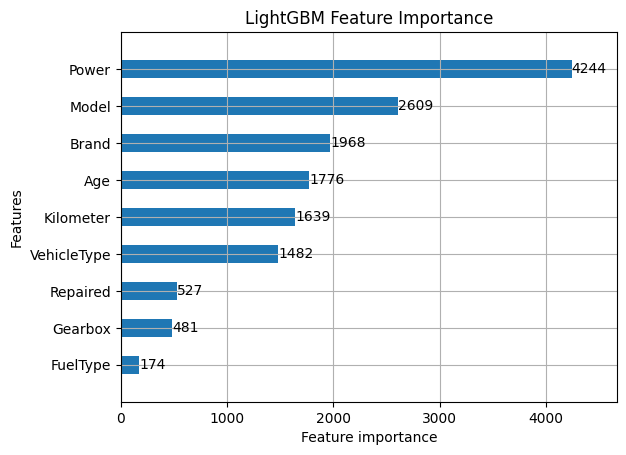

In [50]:
# Visualize feature importance
plot_importance(best_model, height=0.5)
plt.title('LightGBM Feature Importance')
plt.show()

- `Power` is the leading parameter, which aligns with market reality as engine power significantly affects car value.
- The following features also show high importance: `Model`, `Brand`, `Age`, `Kilometer` and `VehicleType`.
- The least significant features for this model are `Repaired`, `Gearbox`, and `FuelType`.

## <a name='Conclusion'></a> General Conclusion

This project aimed to develop a machine learning model to predict the market value of used cars for the "Rusty but Trusty" service.

**Data Preprocessing & Engineering**
- **Missing Values**: Handled missing data in `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Repaired` by assigning `other` or `unknown` labels.
- **Outlier Management**: Capped Power at 1000 hp and filtered the lower 5% of Price to remove anomalies. `RegistrationYear` was restricted to the 1900–2016 range.
- **Feature Engineering**: Created a categorical `Age` feature (new to retro) derived from `RegistrationYear` and `DateCrawled`.
- **Dimensionality Reduction**: Dropped non-informative features (e.g., `PostalCode`, `DateCreated`, `NumberOfPictures`) and removed duplicates to improve model efficiency.

**Modeling & Performance**
- The data was split 75:25 into training and test sets. We evaluated three models based on the client's criteria: **quality (RMSE)**, **training speed**, and **prediction latency**.
- Linear Regression* provided the fastest predictions but failed to meet quality standards due to high RMSE.
- **LightGBM** outperformed others in both training speed and accuracy. On the test set, LightGBM achieved an **RMSE of 1853.32**, significantly better than the required threshold of 2500.

**Feature Insights**
- The **LightGBM** feature importance analysis revealed that:
- `Power` is the most critical driver of car value.
- `Model`, `Brand`, `Age`, `Kilometer`, and `VehicleType` follow as secondary key features.
- `Repaired`, `Gearbox`, and `FuelType` have the least impact on the final price prediction.

**Final Recommendation**
Based on the balance of prediction quality, training efficiency, and low latency, LightGBM is the recommended model for production. It meets all technical requirements and provides the business with a scalable tool for real-time car valuation.